In [1]:
import gymnasium as gym
from gymnasium import spaces

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

ticker = "MSFT"
df = yf.download(ticker, period='60d', interval="2m")

df.columns = [i[0] for i in df.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:


# Function to compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute MACD
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Compute Indicators
df["SMA_10"] = df["High"].rolling(window=10).mean()
df["EMA_10"] = df["High"].ewm(span=10, adjust=False).mean()
df["RSI_14"] = compute_rsi(df["High"], window=14)
df["MACD"], df["Signal_Line"] = compute_macd(df["High"])
df["BB_Mid"] = df["High"].rolling(window=20).mean()
df["BB_Std"] = df["High"].rolling(window=20).std()
df["BB_Upper"] = df["BB_Mid"] + (df["BB_Std"] * 2)
df["BB_Lower"] = df["BB_Mid"] - (df["BB_Std"] * 2)

price_volume = (df["High"] * df["Volume"]).rolling(window=20).sum().shift(1)
volume_sum = df["Volume"].rolling(window=20).sum().shift(1)
df["VWAP"] = price_volume / volume_sum


fib_window = 26  # adjust to match your feature engineering style

rolling_high = df["High"].rolling(window=fib_window).max().shift(1)
rolling_low = df["Low"].rolling(window=fib_window).min().shift(1)

df["Fib_23.6"] = rolling_low + 0.236 * (rolling_high - rolling_low)
df["Fib_38.2"] = rolling_low + 0.382 * (rolling_high - rolling_low)
df["Fib_61.8"] = rolling_low + 0.618 * (rolling_high - rolling_low)

df.drop(columns=["BB_Std"], inplace=True)

# Shift indicators to prevent data leakage

for col in ["SMA_10", "EMA_10", "RSI_14", "MACD", "Signal_Line", "VWAP", "BB_Mid", "BB_Upper", "BB_Lower"]:
    df[col] = df[col].shift(1)

# Drop NaN values resulting from rolling calculations
df.dropna(inplace=True)


In [4]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-03-03 15:22:00+00:00,394.140015,394.535187,393.691193,393.820007,106536,393.762250,393.936588,39.770921,-0.947974,-1.037332,394.425993,396.327067,392.524919,394.680206,393.720293,394.694846,396.270150
2025-03-03 15:24:00+00:00,394.054993,394.479889,393.859985,394.220001,79951,393.867767,394.045424,50.510883,-0.839062,-0.997678,394.354878,396.115990,392.593767,394.542172,393.526772,394.381603,395.763386
2025-03-03 15:26:00+00:00,394.425995,394.750000,393.859985,394.054993,86296,393.931757,394.124418,54.943700,-0.748581,-0.947859,394.290373,395.923069,392.657677,394.467633,393.392250,394.163860,395.411121
2025-03-03 15:28:00+00:00,394.625000,394.682007,394.149994,394.429993,63936,394.030756,394.238160,53.436186,-0.647614,-0.887810,394.222878,395.637669,392.808086,394.398890,393.176315,393.814339,394.845665
2025-03-03 15:30:00+00:00,394.350006,395.000000,394.279999,394.614990,97494,394.175806,394.318859,57.839074,-0.566552,-0.823558,394.154478,395.304917,393.004040,394.291776,393.138857,393.753707,394.747575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14 19:50:00+00:00,388.242004,388.549988,387.529999,388.470001,128767,389.415988,389.414967,30.681686,0.061546,0.177373,389.685298,390.399318,388.971278,389.724457,388.591444,388.920220,389.451667
2025-04-14 19:52:00+00:00,387.980011,388.390015,387.739990,388.320007,108871,389.309988,389.257698,25.825218,-0.013845,0.139129,389.622298,390.494761,388.749834,389.665360,388.186525,388.592681,389.249207
2025-04-14 19:54:00+00:00,387.484985,388.369995,387.214996,388.010010,151333,389.221869,389.099938,18.613386,-0.085516,0.094200,389.530798,390.515897,388.545699,389.538842,388.186525,388.592681,389.249207


In [5]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

## Step is to trade one stock at a time

In [7]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_cash=1000, initial_stock=10, context_width=10, offset=3):
        super(TradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.initial_stock = initial_stock  # NEW

        self.context_width = context_width
        self.offset = offset
        self.num_features = df.shape[1]

        self.action_space = spaces.Discrete(3)

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.context_width, self.num_features + 2),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.context_width
        self.cash = self.initial_cash
        self.stock_held = self.initial_stock  # NEW

        if seed is not None:
            np.random.seed(seed)

        obs = self._get_obs()
        info = {}
        return obs, info

    def render(self, mode="human"):
        if self.current_step >= len(self.df):
            print("End of data reached. No further rendering possible.")
            return

        price = self.df.iloc[self.current_step]["High"]
        net_worth = self.cash + self.stock_held * price
        profit_loss = net_worth - (self.initial_cash + self.initial_stock * price)
        status = "PROFIT" if profit_loss > 0 else "LOSS" if profit_loss < 0 else "BREAKEVEN"

        print(f"Step: {self.current_step}, Cash: {self.cash:.2f}, Stock: {self.stock_held}, "
              f"Net Worth: {net_worth:.2f}, P/L: {profit_loss:.2f} ({status})")



    def _get_obs(self):
        window = self.df.iloc[self.current_step - self.context_width:self.current_step].values.astype(np.float32)
        cash_stock = np.array([[self.cash, self.stock_held]] * self.context_width, dtype=np.float32)
        obs = np.concatenate((window, cash_stock), axis=1)
        return obs  # 2D now: [context_width x (features + 2)]

    def step(self, action):
        terminated = False
        truncated = False
        info = {}
    
        current_price = self.df.iloc[self.current_step]["High"]
        prev_net_worth = self.cash + self.stock_held * current_price
    
        # Execute action
        if action == 1 and self.cash >= current_price:  # Buy
            units_to_buy = int(self.cash // current_price)
            self.cash -= units_to_buy * current_price
            self.stock_held += units_to_buy
    
        elif action == 2 and self.stock_held > 0:  # Sell
            self.cash += self.stock_held * current_price
            self.stock_held = 0
    
        # else Hold (action == 0): do nothing
    
        self.current_step += 1
        if self.current_step + self.offset >= len(self.df):
            terminated = True
            self.current_step = len(self.df) - 1
    
        # New net worth after action
        new_price = self.df.iloc[self.current_step]["High"]
        net_worth = self.cash + self.stock_held * new_price
    
        # Core Reward: Relative Net Worth Growth
        reward = (net_worth - prev_net_worth) / (prev_net_worth + 1e-6)
    
        # Optional: discourage idle holding
        if action == 0:
            reward -= 0.001
    
        # Final net worth bonus (terminal reward)
        if terminated:
            reward += (net_worth - self.initial_cash) / self.initial_cash
    
        obs = self._get_obs()
        return obs, reward, terminated, truncated, info


In [8]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-03-03 15:22:00+00:00,394.140015,394.535187,393.691193,393.820007,106536,393.762250,393.936588,39.770921,-0.947974,-1.037332,394.425993,396.327067,392.524919,394.680206,393.720293,394.694846,396.270150
2025-03-03 15:24:00+00:00,394.054993,394.479889,393.859985,394.220001,79951,393.867767,394.045424,50.510883,-0.839062,-0.997678,394.354878,396.115990,392.593767,394.542172,393.526772,394.381603,395.763386
2025-03-03 15:26:00+00:00,394.425995,394.750000,393.859985,394.054993,86296,393.931757,394.124418,54.943700,-0.748581,-0.947859,394.290373,395.923069,392.657677,394.467633,393.392250,394.163860,395.411121
2025-03-03 15:28:00+00:00,394.625000,394.682007,394.149994,394.429993,63936,394.030756,394.238160,53.436186,-0.647614,-0.887810,394.222878,395.637669,392.808086,394.398890,393.176315,393.814339,394.845665
2025-03-03 15:30:00+00:00,394.350006,395.000000,394.279999,394.614990,97494,394.175806,394.318859,57.839074,-0.566552,-0.823558,394.154478,395.304917,393.004040,394.291776,393.138857,393.753707,394.747575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14 19:50:00+00:00,388.242004,388.549988,387.529999,388.470001,128767,389.415988,389.414967,30.681686,0.061546,0.177373,389.685298,390.399318,388.971278,389.724457,388.591444,388.920220,389.451667
2025-04-14 19:52:00+00:00,387.980011,388.390015,387.739990,388.320007,108871,389.309988,389.257698,25.825218,-0.013845,0.139129,389.622298,390.494761,388.749834,389.665360,388.186525,388.592681,389.249207
2025-04-14 19:54:00+00:00,387.484985,388.369995,387.214996,388.010010,151333,389.221869,389.099938,18.613386,-0.085516,0.094200,389.530798,390.515897,388.545699,389.538842,388.186525,388.592681,389.249207


## FALSE : offset = 5 → the model only trains/predicts every 5 steps## TRUE : offset = 5 → each action’s reward is based on what happens 5 steps in the future



In [10]:
# ---------------------------
# Training
# ---------------------------
context_width = 10
offset = 1

split_point = int(len(df) * 0.7)
train_df = df[:split_point]
test_df = df[split_point:]

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN

train_env = TradingEnv(train_df, context_width=context_width, offset=offset)
train_env = DummyVecEnv([lambda: train_env])

steps_per_episode = df.shape[0] - context_width
total_timesteps = 100 * steps_per_episode

model = DQN("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=total_timesteps)




Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 483      |
|    time_elapsed     | 34       |
|    total_timesteps  | 16780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 299      |
|    n_updates        | 4169     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.469    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 454      |
|    time_elapsed     | 73       |
|    total_timesteps  | 33560    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 278      |
|    n_updates        | 8364     |
----------------------------------
----------------------------------
| rollout/            |          |
| 

Step: 11, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -2.67 (LOSS)
Step: 12, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: 0.38 (PROFIT)
Step: 13, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -3.82 (LOSS)
Step: 14, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -3.77 (LOSS)
Step: 15, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -5.01 (LOSS)
Step: 16, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -4.27 (LOSS)
Step: 17, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -1.32 (LOSS)
Step: 18, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -1.97 (LOSS)
Step: 19, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -5.12 (LOSS)
Step: 20, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -10.02 (LOSS)
Step: 21, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -11.52 (LOSS)
Step: 22, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -12.07 (LOSS)
Step: 23, Cash: 4792.58, Stock: 0, Net Worth: 4792.58, P/L: -12.62 (LOSS)
Step: 24, Cash: 4792.58, Stock: 0, Net Worth: 

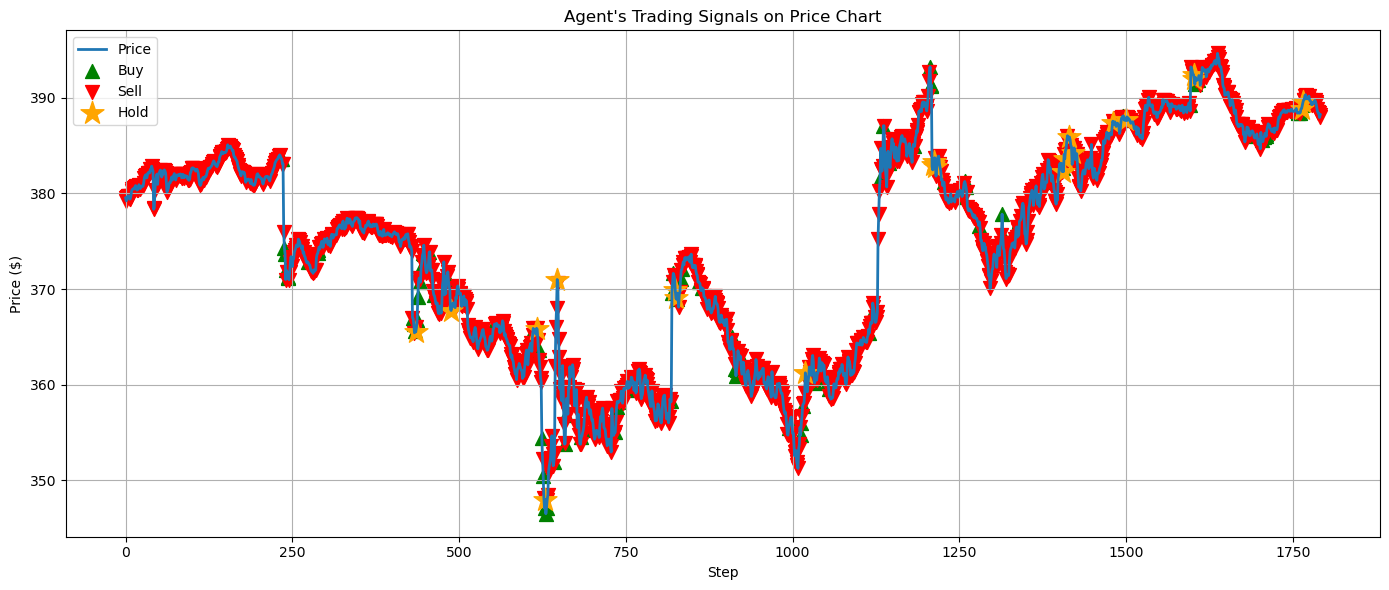

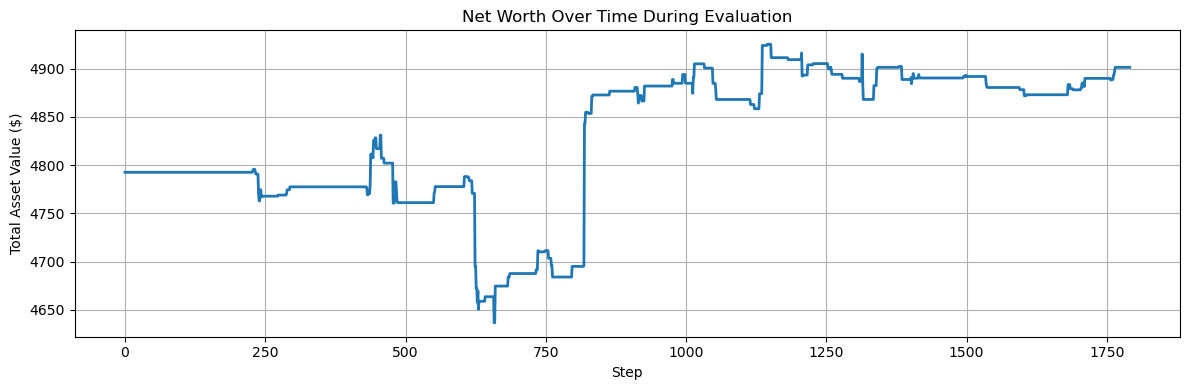

In [11]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df, context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Logging actions, prices, net worth...
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["High"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)

    # SEE RENDER OUTPUT
    test_env.render()  

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='*', color='orange', s=300, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

Step: 11, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: 5.60 (PROFIT)
Step: 12, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -3.10 (LOSS)
Step: 13, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -2.90 (LOSS)
Step: 14, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -9.49 (LOSS)
Step: 15, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -11.50 (LOSS)
Step: 16, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -13.60 (LOSS)
Step: 17, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -16.85 (LOSS)
Step: 18, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -16.00 (LOSS)
Step: 19, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -15.10 (LOSS)
Step: 20, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -23.00 (LOSS)
Step: 21, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -21.70 (LOSS)
Step: 22, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -19.95 (LOSS)
Step: 23, Cash: 4729.20, Stock: 0, Net Worth: 4729.20, P/L: -15.95 (LOSS)
Step: 24, Cash: 4729.20, Stock: 0, Net Wo

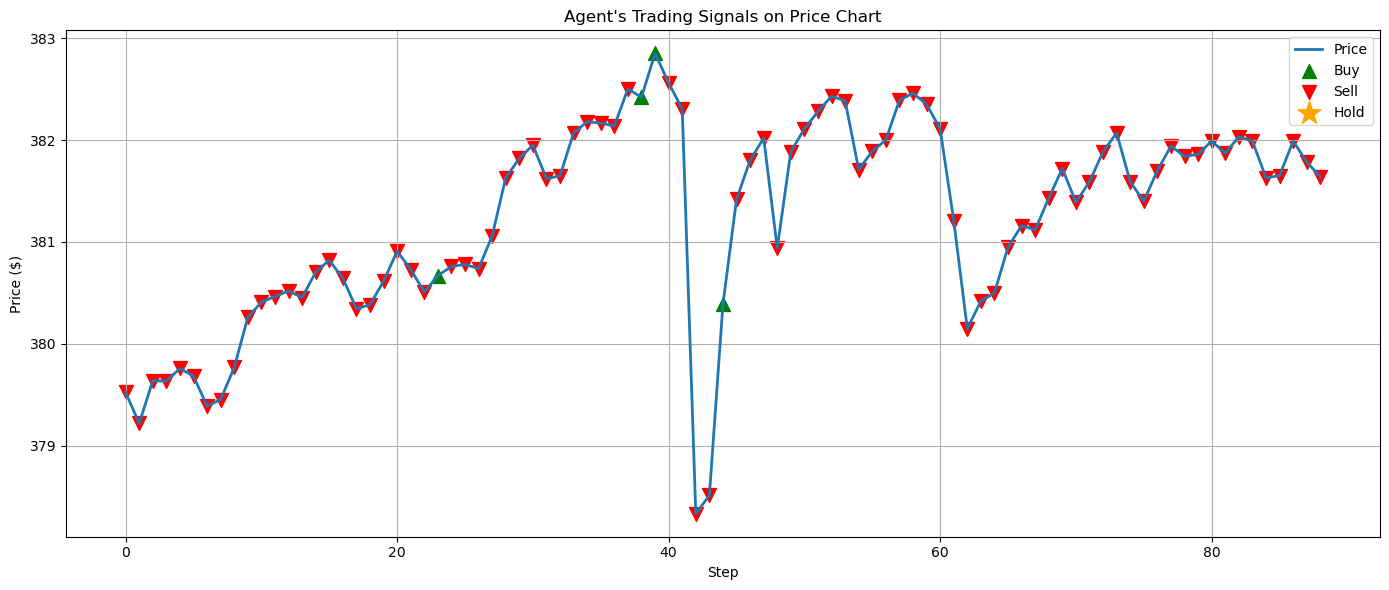

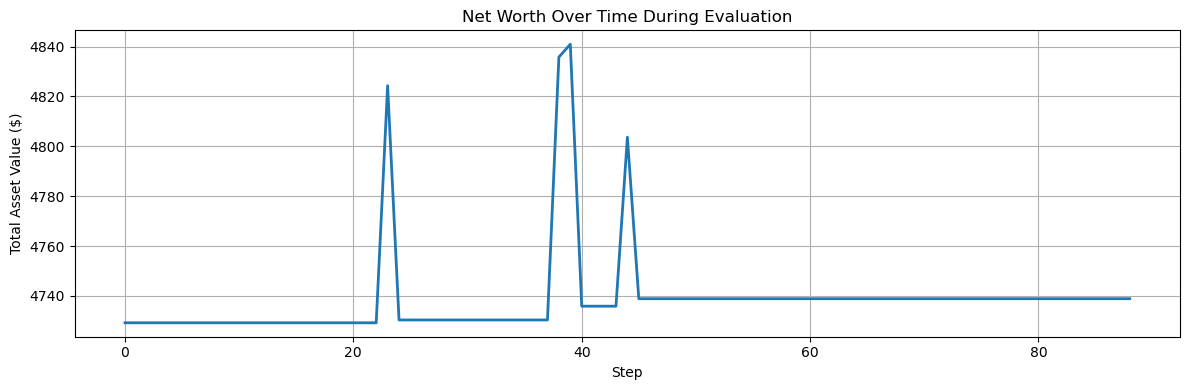

In [12]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df[250:350], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Tracking
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["High"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()  
    

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='*', color='orange', s=300, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

Step: 11, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 5.17 (PROFIT)
Step: 12, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 5.27 (PROFIT)
Step: 13, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 4.52 (PROFIT)
Step: 14, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 16.77 (PROFIT)
Step: 15, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 18.17 (PROFIT)
Step: 16, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 12.27 (PROFIT)
Step: 17, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 11.32 (PROFIT)
Step: 18, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 7.37 (PROFIT)
Step: 19, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 17.17 (PROFIT)
Step: 20, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 10.87 (PROFIT)
Step: 21, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 14.47 (PROFIT)
Step: 22, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 12.47 (PROFIT)
Step: 23, Cash: 4700.17, Stock: 0, Net Worth: 4700.17, P/L: 20.87 (PROFIT)
Step: 24, Cash: 4700.17, Stoc

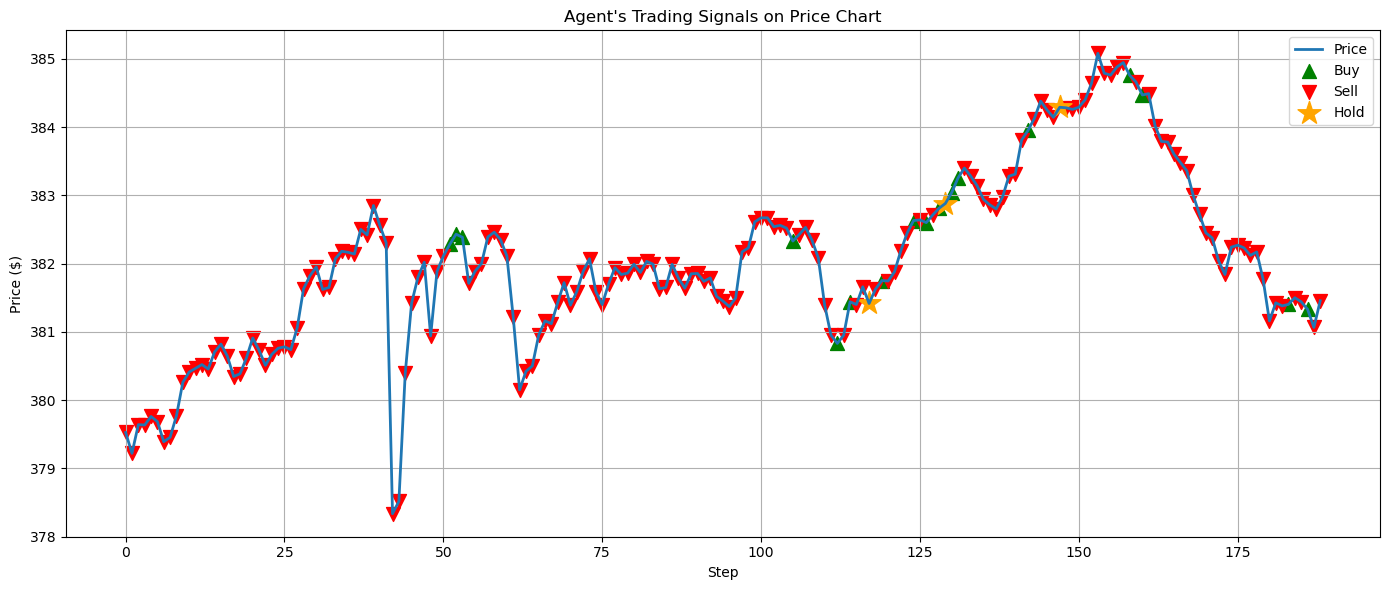

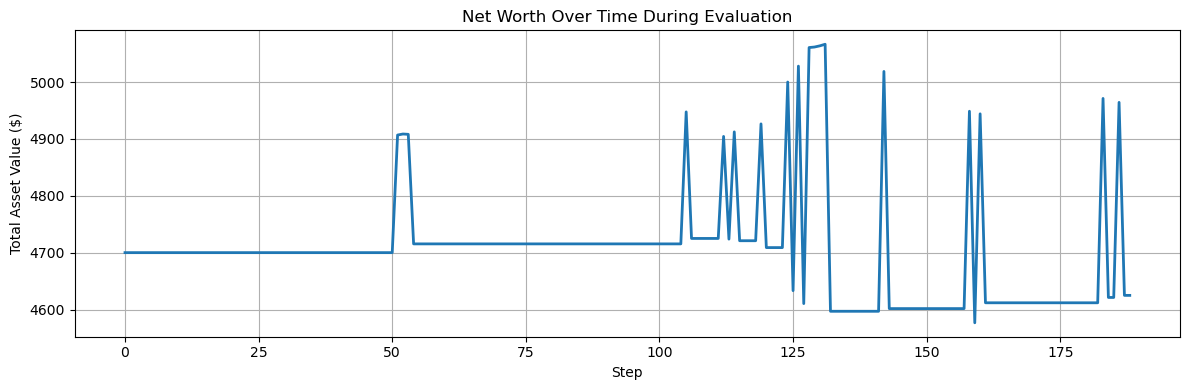

In [13]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df[500:700], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Tracking
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["High"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()  
    

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='*', color='orange', s=300, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

Step: 11, Cash: 4720.77, Stock: 0, Net Worth: 4720.77, P/L: -0.48 (LOSS)
Step: 12, Cash: 4720.77, Stock: 0, Net Worth: 4720.77, P/L: -10.93 (LOSS)
Step: 13, Cash: 4720.77, Stock: 0, Net Worth: 4720.77, P/L: -15.83 (LOSS)
Step: 14, Cash: 4720.77, Stock: 0, Net Worth: 4720.77, P/L: -10.93 (LOSS)
Step: 15, Cash: 4720.77, Stock: 0, Net Worth: 4720.77, P/L: -11.73 (LOSS)
Step: 16, Cash: 4720.77, Stock: 0, Net Worth: 4720.77, P/L: -10.43 (LOSS)
Step: 17, Cash: 4720.77, Stock: 0, Net Worth: 4720.77, P/L: -1.88 (LOSS)
Step: 18, Cash: 4720.77, Stock: 0, Net Worth: 4720.77, P/L: -20.98 (LOSS)
Step: 19, Cash: 4720.77, Stock: 0, Net Worth: 4720.77, P/L: -24.23 (LOSS)
Step: 20, Cash: 226.77, Stock: 12, Net Worth: 4717.77, P/L: -24.73 (LOSS)
Step: 21, Cash: 4717.77, Stock: 0, Net Worth: 4717.77, P/L: -17.35 (LOSS)
Step: 22, Cash: 4717.77, Stock: 0, Net Worth: 4717.77, P/L: -26.53 (LOSS)
Step: 23, Cash: 4717.77, Stock: 0, Net Worth: 4717.77, P/L: -30.43 (LOSS)
Step: 24, Cash: 4717.77, Stock: 0, Net W

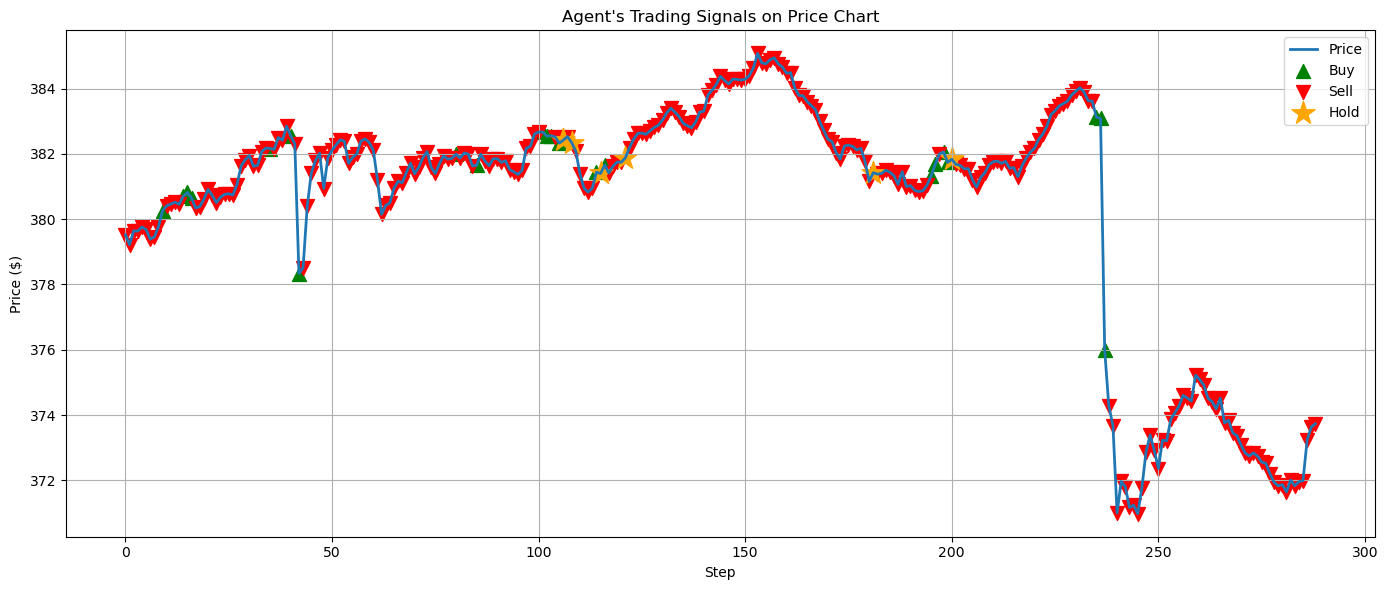

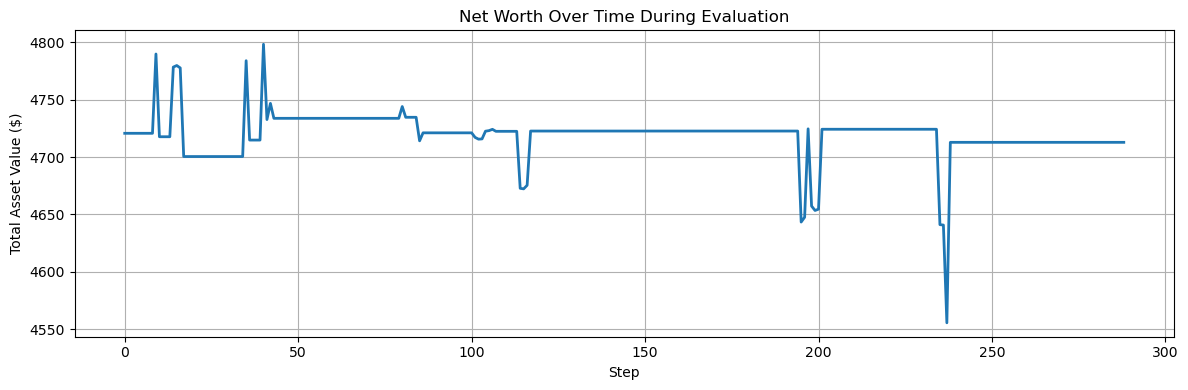

In [14]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df[1300:1600], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Logging actions, prices, net worth...
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["High"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)

    # SEE RENDER OUTPUT
    test_env.render()  

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='*', color='orange', s=300, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
df.iloc[1700]

Close            379.250000
High             379.820007
Low              379.250000
Open             379.725006
Volume         46521.000000
SMA_10           380.162482
EMA_10           380.159794
RSI_14            51.149869
MACD               0.230137
Signal_Line        0.260961
BB_Mid           380.111617
BB_Upper         380.450268
BB_Lower         379.772965
VWAP             380.104129
Fib_23.6         379.172971
Fib_38.2         379.427522
Fib_61.8         379.838988
Name: 2025-03-13 19:06:00+00:00, dtype: float64

In [16]:
df.iloc[1900]

Close            388.325012
High             388.549988
Low              388.218903
Open             388.500610
Volume         53403.000000
SMA_10           388.504498
EMA_10           388.493090
RSI_14            57.964673
MACD               0.226289
Signal_Line        0.222485
BB_Mid           388.371751
BB_Upper         388.744607
BB_Lower         387.998896
VWAP             388.353991
Fib_23.6         387.357037
Fib_38.2         387.596475
Fib_61.8         387.983511
Name: 2025-03-14 19:18:00+00:00, dtype: float64